In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
from os.path import join as pjoin

sys.path.append('/home/hhansen/DecontextEmbeddings')
import os 
os.environ['EMBEDDING_EVALUATION_DATA_PATH'] = '/home/hhansen/DecontextEmbeddings/helpers/embedding_evaluation/data/'

DATA_DIR = '/home/hhansen/DecontextEmbeddings/data'
os.environ['DATA_DIR'] = DATA_DIR

FIGURE_OUTPUT_DIR = pjoin(DATA_DIR, 'figures', 'similarity_datasets')


from scipy.spatial.distance import squareform


from helpers.embedding_evaluation.evaluate import Evaluation as wordsim_evaluate
from helpers.things_evaluation.evaluate import read_embeddings, load_behav, load_sorting, match_behv_sim, evaluate as run_evaluation
from helpers.data import yield_static_data, load_simlex, load_wordsim
from helpers.similarity_values import rsa_matrix_to_pair_list, get_spose_matrix
from helpers.plot import set_style_and_font_size

set_style_and_font_size()

from scipy.stats import spearmanr, pearsonr

/home/hhansen/DecontextEmbeddings/data


# Similarity distribution

In [2]:
simlex_df = load_simlex()
wordsim_df = load_wordsim()

In [3]:
things_df = get_spose_matrix()
things_list = rsa_matrix_to_pair_list(things_df)
things_list = things_list.rename(columns={'sim': 'human_pred'})

In [4]:
def plot(vec, title, ax, bins):
    ax.hist(vec, bins=bins)
    ax.set_xlabel('Similarity value')
    ax.set_ylabel('Number of word pairs')
    ax.set_title(title)

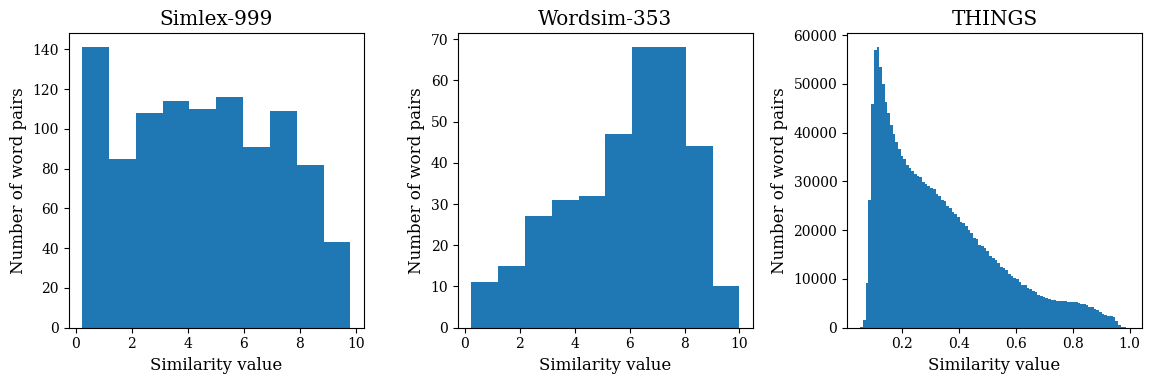

In [5]:
fig, axes = plt.subplots(1,3, figsize=(11.68,4))
plot(simlex_df['human_pred'], 'Simlex-999', axes[0], 10)
plot(wordsim_df['human_pred'], 'Wordsim-353', axes[1], 10)
plot(things_list['human_pred'], 'THINGS', axes[2], 100)
plt.tight_layout()
plt.savefig(pjoin(FIGURE_OUTPUT_DIR, 'dataset_hist.pdf'), bbox_inches='tight')

# Comparison between datasets

# Wordsim

In [ ]:
wordsim_df.sort_values('human_pred', ascending=False).head(10)

# Simlex

In [ ]:
simlex_df.sort_values('human_pred', ascending=False).head(10)

# THINGS

In [ ]:
things_list.sort_values('human_pred', ascending=False).head(10)

# Simlex-Wordsim

In [ ]:
rows = []

for row in wordsim_df.iterrows():
    word1 = row[1].word1
    word2 = row[1].word2
    
    simlex_sim = simlex_df[((simlex_df['word1'] == word1) & (simlex_df['word2'] == word2) | (simlex_df['word1'] == word2) & (simlex_df['word2'] == word1))]
    if not simlex_sim.empty:
        simlex_sim = simlex_sim.reset_index().loc[0, 'human_pred']
        rows.append({'word1': word1, 'word2': word2, 'wordsim_sim': row[1].human_pred, 'simlex_sim': simlex_sim})

intersection_df = pd.DataFrame(rows)
intersection_df['sim_rank'] = intersection_df['simlex_sim'].rank()
intersection_df['wordsim_sim'] = intersection_df['wordsim_sim'].rank()
intersection_df['di^2'] = intersection_df.apply(lambda row: (row['sim_rank'] - row['wordsim_sim']) ** 2, axis=1)
df = intersection_df.sort_values('di^2', ascending=False)
df = df[['word1', 'word2', 'wordsim_sim', 'simlex_sim']]
df

In [ ]:
print(df.to_latex(index=False))

# Simlex-THINGS

In [ ]:
things_words = list(pd.read_csv(f'{DATA_DIR}/things/things_concepts.tsv', sep='\t')['uniqueID'].unique())

In [ ]:
rows = []

for row in simlex_df.iterrows():
    word1 = row[1].word1
    word2 = row[1].word2
    word1_things = word1.replace(' ', '_')
    word2_things = word2.replace(' ', '_')

    try:
        things_sim = things_df.loc[word1, word2]
    except:
        continue
    
    rows.append({'word1': word1, 'word2': word2, 'things_sim': things_sim, 'simlex_sim': row[1].human_pred})

intersection_df = pd.DataFrame(rows)
intersection_df['sim_rank'] = intersection_df['simlex_sim'].rank()
intersection_df['things_rank'] = intersection_df['things_sim'].rank()
intersection_df['di^2'] = intersection_df.apply(lambda row: (row['sim_rank'] - row['things_rank']) ** 2, axis=1)
df = intersection_df.sort_values('di^2', ascending=False).head(10)
df = df[['word1', 'word2', 'things_sim', 'simlex_sim']]
df

In [ ]:
print(df.to_latex(index=False))

# THINGS-Wordsim

In [ ]:
rows = []

for row in wordsim_df.iterrows():
    word1 = row[1].word1
    word2 = row[1].word2
    word1_things = word1.replace(' ', '_')
    word2_things = word2.replace(' ', '_')

    try:
        things_sim = things_df.loc[word1, word2]
    except Exception as e:
        continue
    
    rows.append({'word1': word1, 'word2': word2, 'things_sim': things_sim, 'wordsim_sim': row[1].human_pred})

intersection_df = pd.DataFrame(rows)
intersection_df['thing_rank'] = intersection_df['things_sim'].rank()
intersection_df['wordsim_rank'] = intersection_df['wordsim_sim'].rank()
intersection_df['di^2'] = intersection_df.apply(lambda row: (row['thing_rank'] - row['wordsim_rank']) ** 2, axis=1)

df = intersection_df.sort_values('di^2', ascending=False).head(10)
df = df[['word1', 'word2', 'things_sim', 'wordsim_sim']]
df

In [ ]:
print(df.to_latex(index=False))

# Simlex-Wordsim-THINGS

In [ ]:
rows = []

for row in simlex_df.iterrows():
    word1 = row[1].word1
    word2 = row[1].word2
    word1_things = word1.replace(' ', '_')
    word2_things = word2.replace(' ', '_')  
        
    try:
        things_sim = things_df.loc[word1, word2]
    except:
        continue
    
    wordsim_sim = wordsim_df[((wordsim_df['word1'] == word1) & (wordsim_df['word2'] == word2) | (wordsim_df['word1'] == word2) & (wordsim_df['word2'] == word1))]
    if not wordsim_sim.empty:
        wordsim_sim = wordsim_sim.reset_index().loc[0, 'human_pred']
        rows.append({'word1': word1, 'word2': word2, 'things_sim': things_sim, 'simlex_sim': row[1].human_pred, 'wordsim_sim': wordsim_sim})

intersection_df = pd.DataFrame(rows)
df = intersection_df.sort_values('things_sim', ascending=False).head(30)
df

In [ ]:
print(df.to_latex(index=False))